In [37]:
## Libraries required to run this code

import numpy as np
import copy
import itertools as it
import os
from scipy.special import entr

In [115]:
## import wordlists

data = np.loadtxt('wordlist_solutions.txt',dtype=str)
data2 = np.loadtxt('wordlist_guesses.txt',dtype=str)

## Ensure words are 5 letters

solution_words = [d for d in data if len(d) == 5]   # Words that could be solutions
search_words = [d for d in data2 if len(d) == 5]    # All words that can be entered

#### We need a way to store our information. We have three pieces to store, the letters that are in the right place (green letters) , the letters that we know are not in the word (grey) and the letters that we know are in the word, but we don't know exactly where yet (yellow/orange) .. 

#### We store this information in a ragged list structure called restrictions that includes 3 elements.

## restrictions[0]

#### '_ _ _ _ _' <- this means we don't know any. '
#### '_ _ a _ _' <- this means we know a is in the 3rd position

## restrictions[1] 
#### is a list of letters that we know are not in the word

## restrictions[2] 
#### is a dictionary that contains letters we know are in the word and remembers the positions that we know are not. 

#### {'a':[]} <- We know a is in the word, but we don't know where
#### {'a':[0,2]} <- We know that a is in the word, we don't know where, but we know it's not 1st or third position

In [13]:
## initialise restrictions list
restrictions = ['_____',[],{}]

## The following are functions used in the solver

In [270]:
def comb(n,r):
    nfact = np.math.factorial(n)
    nmrfact = np.math.factorial(n-r)
    rfact = np.math.factorial(r)
    return(nfact/(nmrfact*rfact))

In [365]:
def calc_letter_prob(word_list, restrictions = ['_____',[],{}]):
    '''
    Counts the probability of randomly picking a word in the list that contains a letter
    
    Note: when the letter is already in the solution it then calculates probability of picking a word
    that contains a second instance of that letter.
    
    '''
    alpha = ['a','b','c','d','e','f','g','h','i','j',
             'k','l','m','n','o','p','q','r','s','t',
             'u','v','w','x','y','z' ]
    word_count = len(word_list)
    letter_frequency = {}
    for a in alpha:
        letter_frequency[a] = 0
    for word in word_list:
        found = []
        for letter in word:
            found.append(letter)
            fl = found.count(letter)
            if fl > restrictions[0].count(letter):
                if letter*fl in letter_frequency:
                    letter_frequency[letter*fl] += 1
                else:
                    letter_frequency[letter*fl] = 1
    for f in letter_frequency:
        if word_count > 0:
            letter_frequency[f] = letter_frequency[f]/((word_count))
        else:
            letter_frequency[f] = 0
            
    return(letter_frequency)

['wheel', 'whirl']


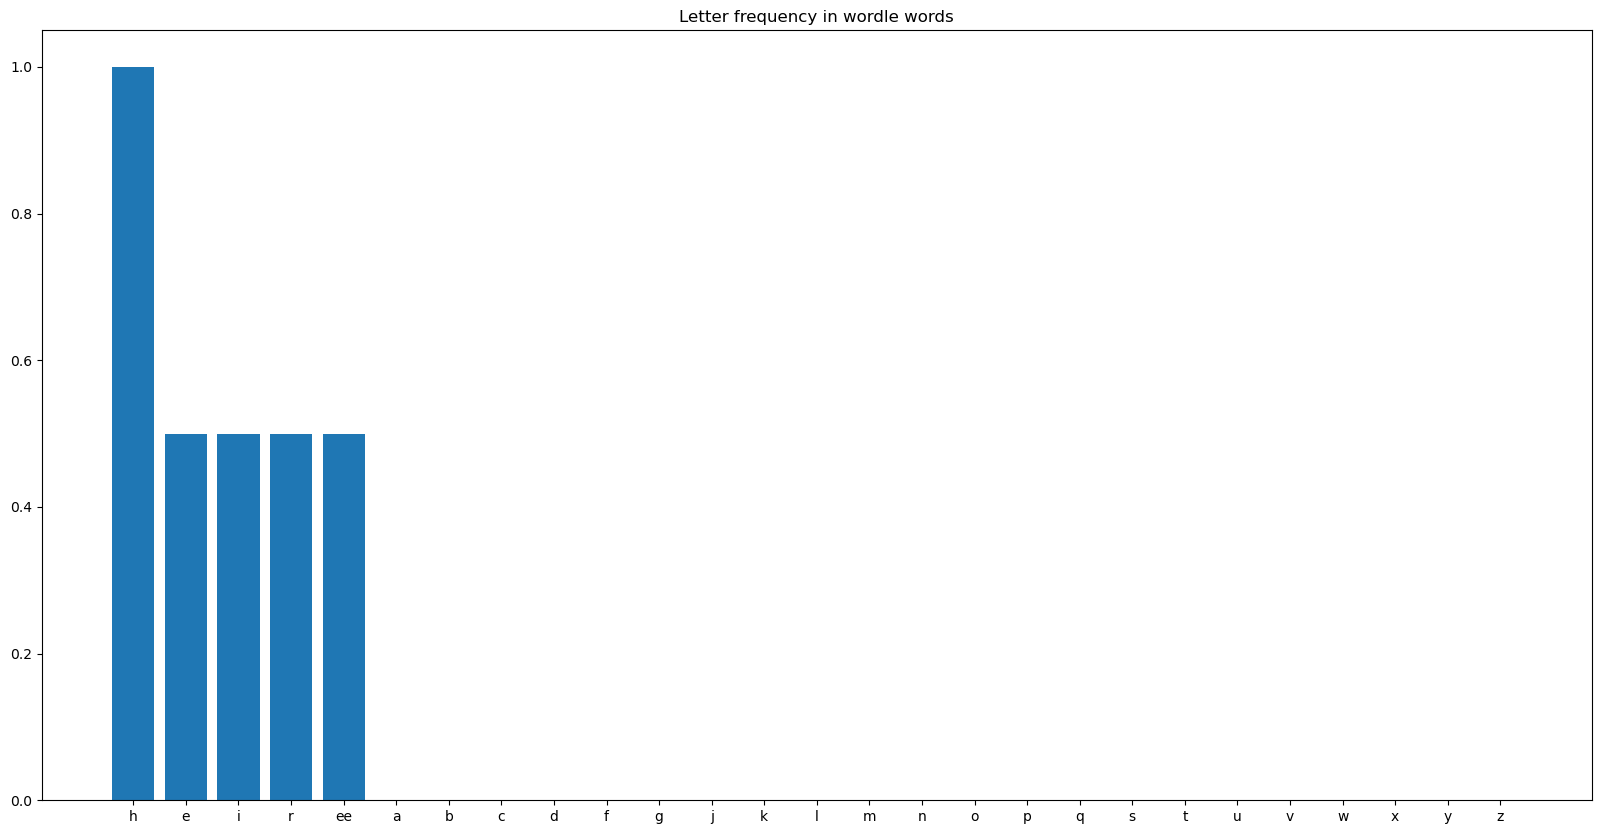

In [364]:
## Test the letter probability function
import matplotlib.pyplot as plt

restrictions = ['_____',[],{}]
pos = restrict_word_list(solution_words, restrictions)
print(pos)
letter_frequencies = calc_letter_prob(pos, restrictions)
sorted_freq = dict(sorted(letter_frequencies.items(),key= lambda x:x[1],reverse= True))
plt.figure(figsize=(20,10))

plt.bar(sorted_freq.keys(), sorted_freq.values())
plt.title('Letter frequency in wordle words')
plt.show()


In [74]:
def restrict_word_list(word_list, restrictions):
    '''
    Takes a word list and a set of restrictions and removes all impossible words
    '''
    output = []
    for word in word_list:
        add_to_list = True
        for count, r in enumerate(restrictions[0]):
            if r == '_':
                pass
            else:
                if r != word[count]:
                    add_to_list = False
        for letter in word:
            if letter in restrictions[1]:
                add_to_list = False
        for res in restrictions[2]:
            if res not in word:
                add_to_list = False
            for pos in restrictions[2][res]:
                if list(word)[pos] == res:
                    add_to_list = False
        if add_to_list:
            output.append(word)
    return(output)

In [75]:
## Test restrict_word_function
words = ['hairy', 'scary' , 'witch']
## Lets assume we know a is in the word..
restricted_words = restrict_word_list(words, ['_____',[],{'a':[]}])
print(restricted_words)

['hairy', 'scary']


In [76]:
def calc_entropy(dic1):
    '''
    takes a dictionary of stored probabilities and calculates the entropy 
    '''
    entropy = entr(list(dic1.values()))
    return(np.sum(entropy))

In [367]:
def calc_entropy_for_words(wordlist, words, restrictions):
    '''
    calculates the expected entropy by considering each possible case for the word.
    NOTE:
    there are 3 possible situations for each letter in the word. 5 letters. so there
    are 3^5 = 243 possible results for the word.
    
    for each letter : 
    
    1. The letter is not in the solution
    2. The letter is in a specific location
    3. The letter is in the word, but not in the specific location.
    
    for each of the cases there is a probability associated with it, the expected entropy is
    the weighted sum of the Entropy from each case.
    '''

    entropy_list = []  
    prob_list = []
    possible_outcomes = list(it.product([0,1,2],[0,1,2],[0,1,2],[0,1,2],[0,1,2]))
    for word in words:
        wordent = []
        for outcome in possible_outcomes:
            res = copy.deepcopy(restrictions) ## copy original restrictions
            for c,i in enumerate(outcome):
                if i == 0:
                    res[1].append(word[c])
                if i == 1:
                    known = list(res[0])
                    known[c] = word[c]
                    res[0] = "".join(known)
                if i == 2:
                    if word[c] not in res[2]:
                        res[2][word[c]] = []
                    if c not in res[2][word[c]]:
                        res[2][word[c]].append(c)
                
            res_wordlist = restrict_word_list(wordlist, res)
            prob = len(res_wordlist) / len(wordlist) 
            lf = calc_letter_prob( res_wordlist )
            entropy = calc_entropy( lf)
            wordent.append(entropy * prob)
        entropy_list.append(np.sum(wordent))
    return(entropy_list)


In [368]:
def pickword(possible_words, wordlist, restrictions):
    res = copy.deepcopy(restrictions) ## copy original restrictions
    wordlist = restrict_word_list(possible_words, res)
    if len(wordlist)<3:
        return(wordlist[0])
    res2 = ['_____',res[1],{}]
    possible_words = restrict_word_list(possible_words, res2)      
    entropies = calc_entropy_for_words(wordlist,possible_words,restrictions)
    sols = []
    for c,word in enumerate(possible_words):
        if entropies[c] != 0:
            sols.append([entropies[c],word])
    sols.sort()
    worst = sols[-5:]
    best = sols[:5]
    print('worst')
    print(worst)
    print('best')
    print(best)
    return(possible_words[np.argmin(entropies)])

In [ ]:
## These are functions to update the knowledge we know after a round.

def update_correct_letters(data, guess, solution):
    for c,i in enumerate(guess):
        if i in solution and i != solution[c]:
            if str(i) not in data[2]:
                data[2][str(i)]=[]
            data[2][str(i)].append(c)
    return(data[2])

def update_incorrect_letters(data, guess, solution):
    for c,i in enumerate(guess):
        if i not in solution and i not in data[1]:
            data[1].append(i)
    return(data[1]) 

def update_solution(data, guess, solution):
    for c,i in enumerate(guess):
        if i == solution[c]:
            data[0][c] = i
    return(data[0])

In [369]:
def run_game(solution, solution_words, search_words):
    
    data = {}
    turns = 1 # We are already guessing 'crane' as out starter word so start counting from 1
    solved = False
    next_guess = ''
    game_data = [list('_____'),list(''),{}]



    first_guess = 'crane'
    game_data[2] = update_correct_letters(game_data, first_guess, solution)
    game_data[0] = update_solution(game_data, first_guess, solution)
    game_data[1] = update_incorrect_letters(game_data, first_guess, solution)


    possibles = solution_words
    allowable_words = search_words

    while turns < 6 and solved == False:
        next_guess = pickword(solution_words, search_words ,game_data)
        turns += 1
        if solution == next_guess:
            print('Well done! The word was ' + solution)
            print('solved in ' + str(turns) +' turns')
            solved = True
            return(turns)
        else:
            game_data[2] = update_correct_letters(game_data, next_guess, solution)
            game_data[0] = update_solution(game_data, next_guess, solution)
            game_data[1] = update_incorrect_letters(game_data, next_guess, solution)
            print(game_data)

In [171]:
## Randomly select some words from the list 
nums = np.random.randint(0,len(solution_words),100)

In [377]:
## This will run the solver by randomly generating the words from the solutions list and 
## then using the algorithm to solve it.

data = {}
for i in range(10):
    solution = solution_words[nums[i]]
    data[solution] = run_game(solution, solution_words, search_words)

worst
[[3.9853271968198687, 'puppy'], [4.046675779916207, 'booze'], [4.322021536176441, 'queue'], [4.355791493701033, 'ozone'], [4.462664188287919, 'penne']]
best
[[1.6646972688733879, 'solid'], [1.7999394564741964, 'olden'], [1.8115996121557638, 'dimly'], [1.8178219540938831, 'yield'], [1.8329059344283123, 'moldy']]
[['_', '_', '_', '_', '_'], ['c', 'r', 'a', 's', 'l', 'i'], {'n': [3], 'e': [4], 'o': [1], 'd': [4]}]
[['_', '_', '_', 'o', '_'], ['c', 'r', 'a', 's', 'l', 'i', 'm'], {'n': [3, 4], 'e': [4, 1], 'o': [1], 'd': [4, 0]}]
Well done! The word was endow
solved in 4 turns
worst
[[4.095566003128917, 'skunk'], [4.130738173181147, 'khaki'], [4.149172070972076, 'flank'], [4.218556767264013, 'shank'], [4.234425209420702, 'spank']]
best
[[1.2567955296785938, 'login'], [1.2857783902813913, 'lingo'], [1.3211627692840298, 'talon'], [1.358746264841034, 'limbo'], [1.3998576961176852, 'tonal']]
[['_', '_', '_', '_', '_'], ['c', 'r', 'e', 'l', 'g', 'i'], {'a': [2], 'n': [3, 4], 'o': [1]}]
[['

{'endow': 4, 'banjo': 4, 'spilt': 4, 'cyber': 3, 'stand': 3, 'carve': 2, 'vying': 4, 'idiot': 3, 'crock': 4, 'alone': 2}
3.3
10


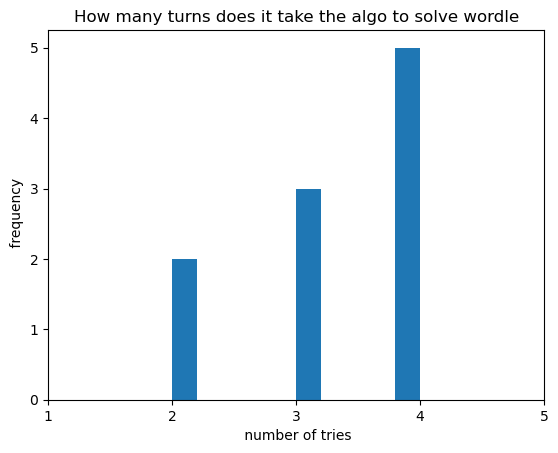

In [385]:
## Plot results

print(data)
print(np.mean(list(data.values())))
print(len(data.values()))
plt.hist(data.values())
plt.xticks([1,2,3,4,5])
plt.xlabel(' number of tries')
plt.ylabel(' frequency')
plt.title('How many turns does it take the algo to solve wordle')
plt.show()